Submitted By: N V J A K Sai Sasank Brahmandam (nb9k7)

Questions the visualizations are trying to answer:

Co-movement & volatility:

How do the four assets (CHOCOLATE, STRAWBERRIES, ROSES, GIFT_BASKET) move relative to each other when rebased to 100?

Which instruments are more/less volatile intraday?

Is the basket fairly priced?

Does GIFT_BASKET track a synthetic fair value constructed from CHOCOLATE, STRAWBERRIES, and ROSES?

What is the strength and stability of that relationship (scatter/hexbin vs. 45-degree line, R²)?

Mispricing & mean-reversion:

What is the spread = (GIFT_BASKET - synthetic) over time?

When the spread's z-score is large (|z| > 2), does it tend to revert? Where are the most actionable deviations?

Order-flow pressure:

Does microprice (best-bid/ask weighted by top-of-book volumes) drift toward the heavier side?

How often does microprice predict the next few ticks of mid-price movement?

Volume imbalance - short-horizon returns:

Does top-of-book volume imbalance correlate with future mid-price returns (impact curve)?

Are there thresholds where signal quality is strongest (e.g., |imbalance| > 0.6)?

Market quality:

What are typical spreads (ask_price_1 − bid_price_1), and do they widen during mispricings?

How deep is liquidity at levels 1–3, and does depth asymmetry line up with price changes?

Intended audience:

Primary: Quantitative researchers, algorithmic trading engineers, and data-driven market microstructure analysts (e.g., trading-competition or market-making coursework).

Secondary: Data scientists with market data (order books, mid-price, spreads).

We have four "friends" in a marketplace:

ROSES

CHOCOLATE

STRAWBERRIES

GIFT BASKET - which is made from the other three!

Traders buy and sell them all day.
We're detectives watching how their prices move together to see if GIFT BASKET is sometimes too expensive or too cheap compared to what it's made of.

The file prices_round_3_day_0.csv is like a big diary that records what happens every few seconds.

In [1]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

In [ ]:
CSV_PATH = "../imc-data/round4/data/prices_round_3_day_0.csv"
df = pd.read_csv(CSV_PATH, sep=";").sort_values(["day","timestamp"])

In [4]:
# Focus on a single day and the four products
df0 = df[df["day"] == 0].copy()
products = ["GIFT_BASKET", "ROSES", "CHOCOLATE", "STRAWBERRIES"]

# Pivot to time x product mid-price
mid = df0.pivot_table(index="timestamp", columns="product",
                      values="mid_price", aggfunc="last").sort_index()

aligned = mid[products].dropna()

A. Rebased Price Paths - "Who moves with whom?"

What the code does:
It takes the prices of all four products and divides each by its first price so everyone starts at 1.0.
That way, we can compare how much each one changes, even if they started at different prices.

What the picture shows:
Four lines (one per product) going up and down together.

Think of it like this:
All four friends are on a trampoline.
If one jumps up, the others often jump too - sometimes a bit later or not as high.
This tells us who follows whom and how tightly they move together.

Why it matters:
If GIFT BASKET always moves in rhythm with the others, it means its price really depends on them.


[A] Market cast - four assets trading together. We look at normalized prices to compare co-movement.



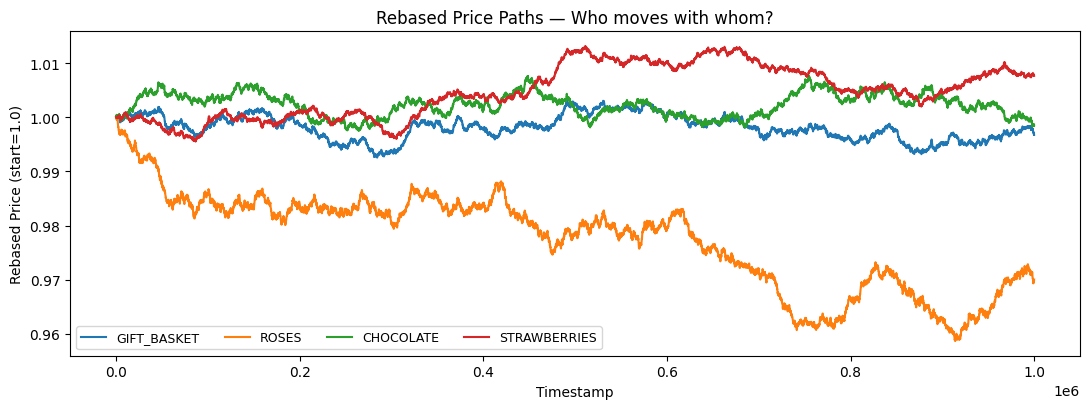

In [5]:
print("\n[A] Market cast - four assets trading together. We look at normalized prices to compare co-movement.\n")
norm = aligned / aligned.iloc[0]  # rebased to 1.0 at start

plt.figure(figsize=(11, 4.2))
for c in norm.columns:
    plt.plot(norm.index.values, norm[c].values, label=c)
plt.xlabel("Timestamp")
plt.ylabel("Rebased Price (start=1.0)")
plt.title("Rebased Price Paths — Who moves with whom?")
plt.legend(ncol=4, fontsize=9)
plt.tight_layout()
plt.show()

B. Basket Parity Map - "Is the basket fairly priced?"

What the code does:
It pretends to rebuild the gift basket from its ingredients:

Synthetic price = ROSES + 4 × CHOCOLATE + 6 × STRAWBERRIES
and then compares that to the actual market price of GIFT BASKET.

It draws lots of tiny dots (like grains of sand) showing where those two prices meet.

What the picture shows:
A cloudy diagonal band around a 45-degree line.
That line means "perfect fairness" - the basket price equals its ingredients' total.

Like a playground balance scale:
If all points were exactly on the line, the basket's price always matches its parts.
Points above the line mean it's a bit overpriced; below means underpriced.

Why it matters:
We now know the basket usually follows its ingredients closely, but sometimes drifts.

[B] Hypothesis: GIFT_BASKET should track a synthetic fair value = ROSES + 4·CHOCOLATE + 6·STRAWBERRIES.
We test this with a parity map (density) and look for a tight ridge around the 45-degree line.



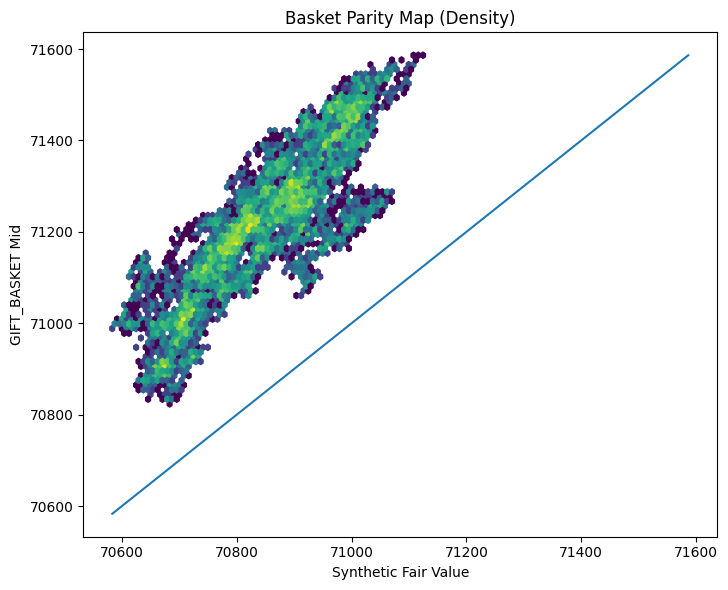

In [7]:
print("[B] Hypothesis: GIFT_BASKET should track a synthetic fair value = ROSES + 4·CHOCOLATE + 6·STRAWBERRIES.\n"
      "We test this with a parity map (density) and look for a tight ridge around the 45-degree line.\n")

aligned = aligned.copy()
aligned["synthetic"] = aligned["ROSES"] + 4.0*aligned["CHOCOLATE"] + 6.0*aligned["STRAWBERRIES"]

plt.figure(figsize=(7.4, 6.0))
plt.hexbin(aligned["synthetic"].values, aligned["GIFT_BASKET"].values,
           gridsize=65, bins="log")
lims = [min(aligned["synthetic"].min(), aligned["GIFT_BASKET"].min()),
        max(aligned["synthetic"].max(), aligned["GIFT_BASKET"].max())]
plt.plot(lims, lims)  # 45-degree line
plt.xlabel("Synthetic Fair Value")
plt.ylabel("GIFT_BASKET Mid")
plt.title("Basket Parity Map (Density)")
plt.tight_layout()
plt.show()

C. Spread Z-Score - "How far did the basket drift?"

What the code does:
It measures the difference between the basket and the synthetic value (called the spread),
then looks at how many "usual wiggles" (standard deviations) away the current spread is.
That's the z-score.

It draws the z-score over time and shades areas where it's really high or low (|z| > 2).

What the picture shows:
A wavy line near 0 most of the time, with some peaks and valleys that enter shaded zones.

Think of it like this:
Imagine a rubber band connecting GIFT BASKET to its fair value.
Most of the time it's loose, but when it stretches too far (into the shaded area), it tends to snap back.

Why it matters:
Those stretches are our "aha!" moments - potential buy or sell signals for a trader who bets on mean-reversion.

[C] Mispricing lens: spread = GIFT_BASKET - synthetic. We standardize it as a rolling z-score.
Shaded regions (|z|>2) are our 'interesting' regimes where mean reversion might occur.



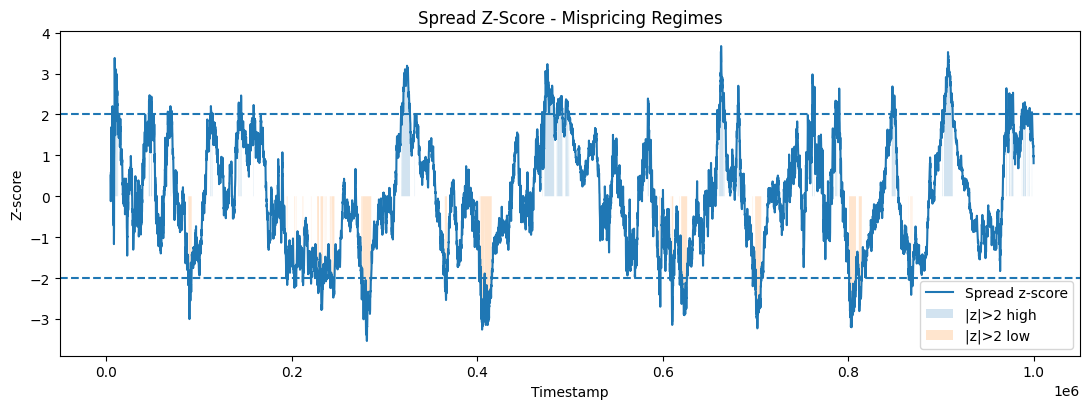

In [8]:
print("[C] Mispricing lens: spread = GIFT_BASKET - synthetic. We standardize it as a rolling z-score.\n"
      "Shaded regions (|z|>2) are our 'interesting' regimes where mean reversion might occur.\n")

spread = aligned["GIFT_BASKET"] - aligned["synthetic"]
W = 500
mu = spread.rolling(W, min_periods=50).mean()
sd = spread.rolling(W, min_periods=50).std(ddof=0)
z = (spread - mu) / (sd.replace(0, np.nan))

plt.figure(figsize=(11, 4.2))
plt.plot(aligned.index.values, z.values, label="Spread z-score")
plt.axhline( 2.0, linestyle="--")
plt.axhline(-2.0, linestyle="--")
# Regime shading
hi = z.where(z >= 2.0).fillna(0).values
lo = z.where(z <= -2.0).fillna(0).values
plt.fill_between(aligned.index.values, 0, hi, alpha=0.2, label="|z|>2 high")
plt.fill_between(aligned.index.values, 0, lo, alpha=0.2, label="|z|>2 low")
plt.xlabel("Timestamp")
plt.ylabel("Z-score")
plt.title("Spread Z-Score - Mispricing Regimes")
plt.legend()
plt.tight_layout()
plt.show()

D. Microprice vs Mid - "Who's pushing harder?"

What the code does:
Looks at the order book, the list of people wanting to buy (bids) or sell (asks).
It calculates the microprice, a kind of "weighted" center based on who's louder (more volume) on each side.

Then it subtracts the normal middle price (mid) from it.

What the picture shows:
A squiggly line that dances above and below zero.

In kid terms:
Imagine a tug-of-war.
If more kids pull on the buy side, the rope moves that way - microprice goes above mid.
If more pull on the sell side, it dips below.

Why it matters:
The rope's direction (microprice - mid) hints which way the price might move next.
Persistent positive pressure = buyers winning.

[D] Order-flow pressure: if the microprice (volume-weighted best quote) diverges from mid,
pressure typically resolves by pulling mid toward micro.



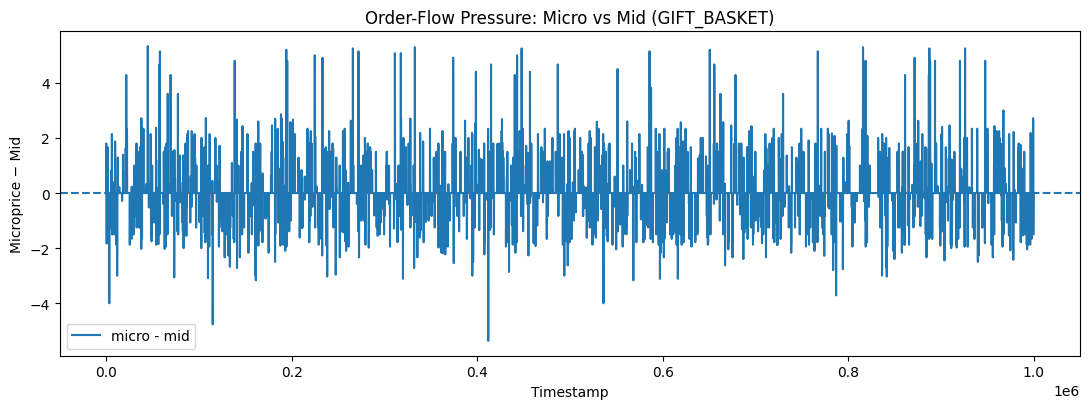

In [9]:
print("[D] Order-flow pressure: if the microprice (volume-weighted best quote) diverges from mid,\n"
      "pressure typically resolves by pulling mid toward micro.\n")

gb = df0[df0["product"] == "GIFT_BASKET"].copy().sort_values("timestamp")
p_b = gb["bid_price_1"].astype(float).values
v_b = gb["bid_volume_1"].astype(float).values
p_a = gb["ask_price_1"].astype(float).values
v_a = gb["ask_volume_1"].astype(float).values
mid_gb = gb["mid_price"].astype(float).values

micro = (p_b*v_a + p_a*v_b) / (v_a + v_b + 1e-9)
div = micro - mid_gb

plt.figure(figsize=(11, 4.2))
plt.plot(gb["timestamp"].values, div, label="micro - mid")
plt.axhline(0, linestyle="--")
plt.xlabel("Timestamp")
plt.ylabel("Microprice − Mid")
plt.title("Order-Flow Pressure: Micro vs Mid (GIFT_BASKET)")
plt.legend()
plt.tight_layout()
plt.show()

E. Imbalance vs Future Return - "Does the tug-of-war predict who wins?"

What the code does:
It takes each moment's imbalance (how much stronger buyers are than sellers)
and checks what happens to the price a little later (50 ticks later).

Then it plots those pairs as little dots.

What the picture shows:
A cloud of points - sometimes slightly tilted upward.

Kid analogy:
If you push a swing harder on one side (more buyers),
does it actually swing up in that direction later?
The scatter plot tests that idea.

Why it matters:
If there's a tilt upward, it means order flow contains predictive information -
a tiny advantage traders could exploit.

[E] Predictability test: top-of-book volume imbalance vs future return over 50 ticks.
If points tilt upward, buy-side pressure (imbalance>0) tends to precede up-moves.



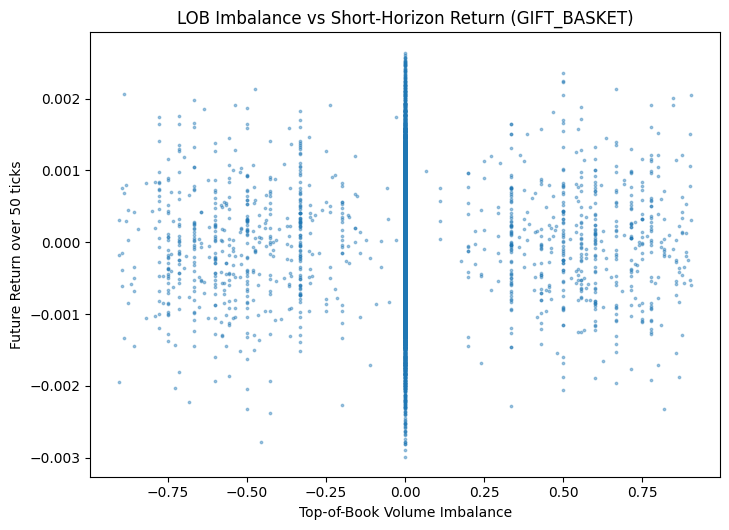

In [10]:
print("[E] Predictability test: top-of-book volume imbalance vs future return over 50 ticks.\n"
      "If points tilt upward, buy-side pressure (imbalance>0) tends to precede up-moves.\n")

imb = (v_b - v_a) / (v_b + v_a + 1e-9)
h = 50
fut_ret = np.full_like(mid_gb, np.nan, dtype=float)
fut_ret[:-h] = (mid_gb[h:] - mid_gb[:-h]) / mid_gb[:-h]

mask = np.isfinite(imb) & np.isfinite(fut_ret)
plt.figure(figsize=(7.4, 5.4))
plt.scatter(imb[mask], fut_ret[mask], s=3, alpha=0.4)
plt.xlabel("Top-of-Book Volume Imbalance")
plt.ylabel(f"Future Return over {h} ticks")
plt.title("LOB Imbalance vs Short-Horizon Return (GIFT_BASKET)")
plt.tight_layout()
plt.show()

Putting the Story Together

The four friends (ROSES, CHOCOLATE, STRAWBERRIES, GIFT BASKET) mostly move together.

The basket usually matches its ingredients' total, but sometimes drifts high or low.

When it drifts too far, it often snaps back - the mean-reversion idea.

You can see market "tug-of-war" pressure in microprice vs mid.

That pressure sometimes hints which way the next move will be.

So even though we used real trading math, the story is simple:

"When something made of parts moves away from what the parts are worth,
and the crowd buying or selling pushes in the same direction,
we can see the market breathing - and maybe predict its next breath."

In [11]:
print("\nTL;DR story: The basket closely tracks a synthetic value, but deviates episodically. "
      "Those deviations show up in the spread z-score and often coincide with order-flow pressure "
      "(micro vs mid). Where both agree, the setup is most compelling.\n")


TL;DR story: The basket closely tracks a synthetic value, but deviates episodically. Those deviations show up in the spread z-score and often coincide with order-flow pressure (micro vs mid). Where both agree, the setup is most compelling.

